# v01

Here we look at appropriate parameterizations that can be computed quickly.  I'll start with just 3x3 kernels, and and my 3x3 blocks.


There are only 3 unique distances.  So this is 3 parameters for scalars.  2 parameters each for vectors.  And 5 parameters for matrix.  This is 12 parameters.

I will need to make sure this is batched appropriately so it can be computed quickly.

Actually because rotations commute in 2D, there are more degrees of freedom.

3 for scalar

4 each for distances

3 for identity, and 2*4 for outer product.

Total of 22 out of a total 36.  So this is half.

# v02
In v02 I'm just getting rid of some debugging stuf from v01


# v03

In v03 I'm making my network deeper, to be about 250k like resnet

# v04
In v04 I use batch norm. no cutout. use real resnet architecture

# v05

Add rotationally invariant norm and bias.

I added a rotationally invariant nonlinearity too.

I have added the rotationally invariant scale and bias to the bn layer.

I did not make bias rotationally invariant in the conv layer, but I never use this bias currently because it is always followed by batchnomrm.

TODO: a layer that goes from scalar fields to vector fields explicitly.



Note i set normalize to mean 0.5, std 0.5 like medmnist did.

note they use default 100 epochs, and reduce stepsize by 0.1 at .50 and .75.  They use adam and an initial learning rate of 1e-3.


For comparison, they used AUC from SKL.  And the averaged it over each label (i.e. one versus all).

For accuracy, they use skl accuracy_score, not balanced.

They also use batch size of 128.

Also, they use the "best model" on the validation set for testing.  This is the one with the best auc.

Another thing, in the medmnist paper they use 4 scales, with 2 repeats per scale.

I think I will likely need more epochs of training.

# v06

Here I will use four layers with two copies in resnet

In v05 and v06 I fixed my sigmoid rot

# v07


# v08

figured out why it was not rotationally invariant.

Need to do averaging when size is even, and skipping when size is odd.

# v09

In version 9 I applied my results to a lot of different datasets.


# v10

In version 10 I'm going to work on my shortcuts.

In [1]:
import torch, torchvision
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget
# use widget in vscode

plt.set_loglevel('critical')

from sklearn.metrics import roc_auc_score

from importlib import reload # while updating code this is important
import models 
from models import train_and_eval

from IPython.display import clear_output, display


In [2]:
# currently I'm not using this
def cutout(I,val=0.5):
    rows = np.random.randint(0,I.shape[-2],(2,))    
    rows.sort()
    cols = np.random.randint(0,I.shape[-1],(2,))    
    cols.sort()
    I[...,rows[0]:rows[1],cols[0]:cols[1]] = val
    return I

In [3]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


In [4]:
my_dataset = torchvision.datasets.CIFAR10(    
    '/home/dtward/data',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                              torchvision.transforms.RandomCrop(32,padding=4,padding_mode='edge'),
                                              torchvision.transforms.ToTensor(),                                              
                                             # torchvision.transforms.Lambda(cutout)
                                              normalize,
                                             ]
                                            )
)
my_loader = DataLoader(my_dataset, batch_size=64, num_workers=8, shuffle=True)

Files already downloaded and verified


In [5]:
my_dataset_test = torchvision.datasets.CIFAR10(    
    '/home/dtward/data',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              normalize,
                                              ])
)
my_loader_test = DataLoader(my_dataset_test, batch_size=64, num_workers=8, shuffle=True)

Files already downloaded and verified


In [6]:
normalize = torchvision.transforms.Normalize(mean=0.5,
                                     std=0.5)
# 0.5, 0.5 is used in medmnist code

In [7]:
from medmnist import DermaMNIST as Dataset
from medmnist import BloodMNIST as Dataset
#from medmnist import OrganAMNIST as Dataset
#from medmnist import PathMNIST as Dataset
#from medmnist import TissueMNIST as Dataset # really big
#from medmnist import BreastMNIST as Dataset # much smaller

In [8]:
my_dataset = Dataset(     
    download=True,
    split='train',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),   
                                              normalize
                                             ]
                                            )
)
my_loader = DataLoader(my_dataset, batch_size=128, num_workers=8, shuffle=True)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


In [9]:
my_dataset_val = Dataset(        
    split='val',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              normalize,
                                             ]
                                            )
)
my_loader_val = DataLoader(my_dataset_val, batch_size=128, num_workers=8, shuffle=True)

In [10]:
my_dataset_test = Dataset(        
    split='test',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              normalize,
                                             ]
                                            )
)
my_loader_test = DataLoader(my_dataset_test, batch_size=128, num_workers=8, shuffle=True)
labels = set()
for x,l in my_loader_test:
    labels_i = {li.squeeze().item() for li in l}
    labels = labels.union(labels_i)
n_labels = len(labels)    
print(n_labels)

8


In [11]:
device = 'cuda:0'

In [12]:
nepochs = 5

# 18 layer resnets from medmnist

## First the actual resnet

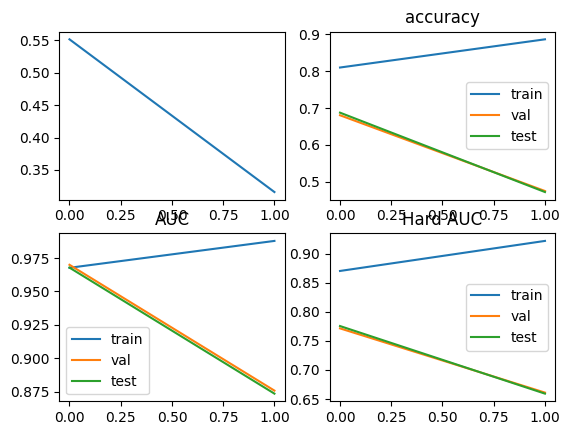

In [13]:
net = models.ResNet18(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 64
out['n_parameters'] = models.count_parameters(net)

out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
resnet18_out = out

## Next the rotnet with the same number of feature maps

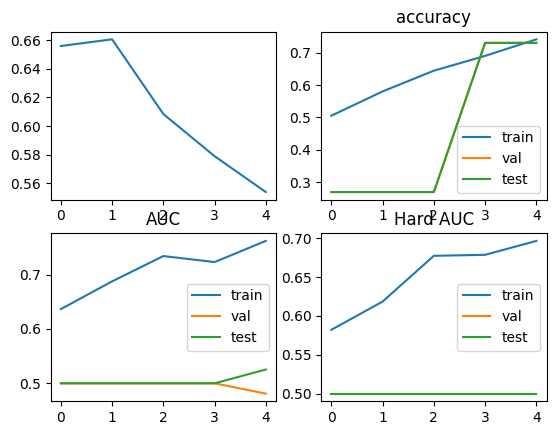

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.525375939849624 0.5 0.7307692307692307


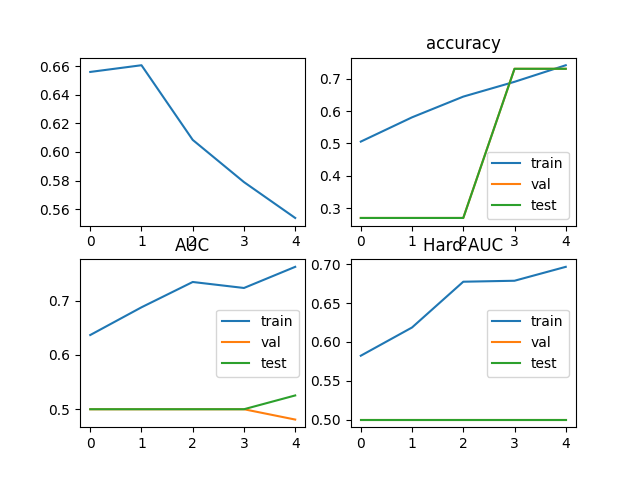

In [ ]:
reload(models)
# this is the "default" which does 63 layers (close to 64, but less)
net = models.RotNet18(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 63
out['n_parameters'] = models.count_parameters(net)

out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet18_out = out

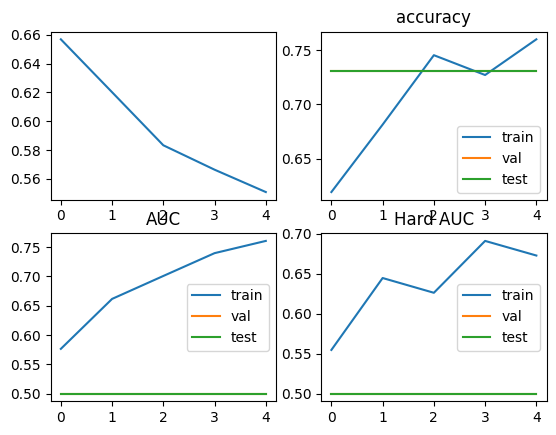

best auc, hard auc, accuracy
0.5 0.5 0.7307692307692307
final auc, hard auc, accuracy
0.5 0.5 0.7307692307692307


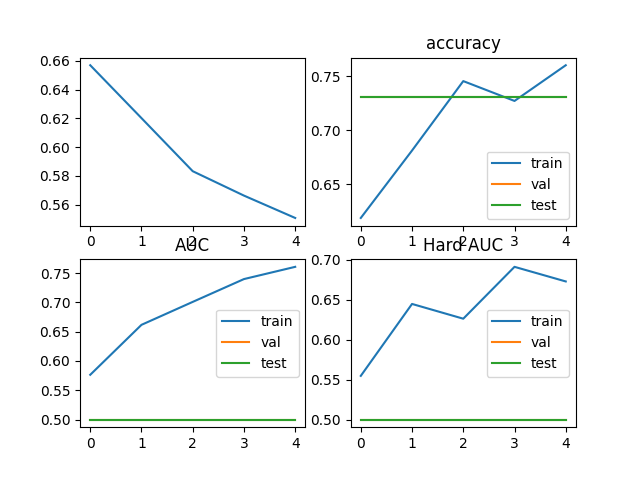

In [ ]:
reload(models)
# this is the "default" which does 63 layers (close to 64, but less)
net = models.RotNet18(n1=n_labels,reflection=True)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 63
out['n_parameters'] = models.count_parameters(net)

out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
refnet18_out = out

## Next the rotnet with the same number of independent feature maps

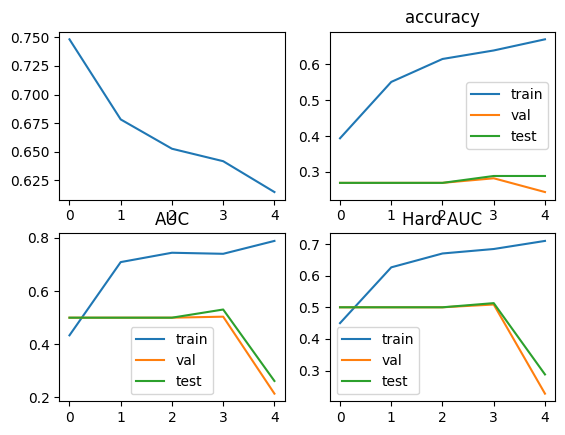

best auc, hard auc, accuracy
0.5307017543859649 0.513157894736842 0.28846153846153844
final auc, hard auc, accuracy
0.26190476190476186 0.28759398496240596 0.28846153846153844


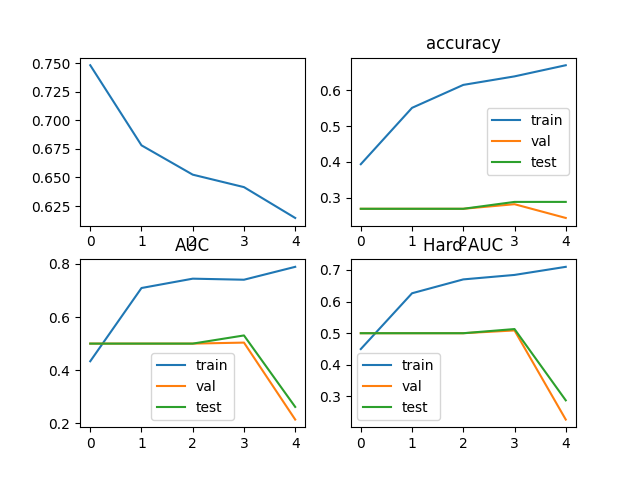

In [ ]:
# 18 layers was used in the medmnist
# or let's try 32 scalars and 32 vectors (since they did 64 total), this would be 96 feature maps
# this is way less parameters
reload(models)
net = models.RotNet18(n0=96,n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 96
out['n_parameters'] = models.count_parameters(net)
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet18_n096_out = out

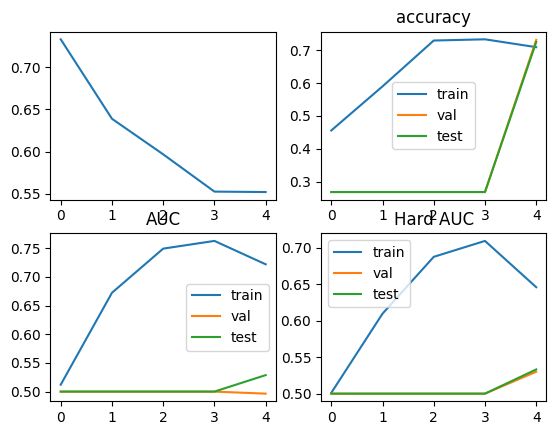

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.5287698412698413 0.5332080200501252 0.7243589743589743


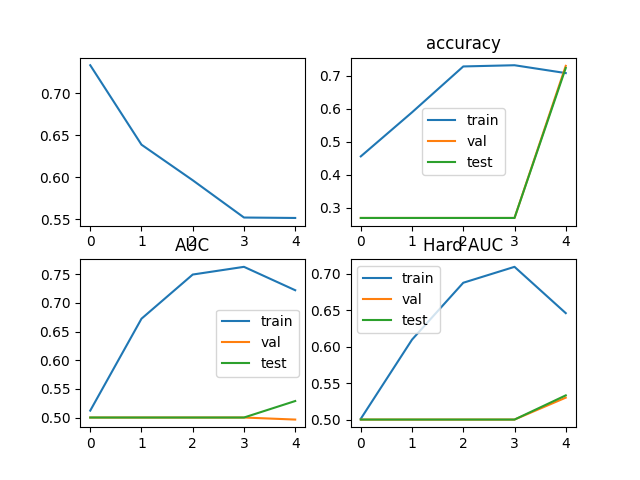

In [ ]:
# 18 layers was used in the medmnist
# or let's try 32 scalars and 32 vectors (since they did 64 total), this would be 96 feature maps
# this is way less parameters
reload(models)
net = models.RotNet18(n0=96,n1=n_labels,reflection=True)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 96
out['n_parameters'] = models.count_parameters(net)

out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
refnet18_n096_out = out

## Last the rotnet with the same number of parameters

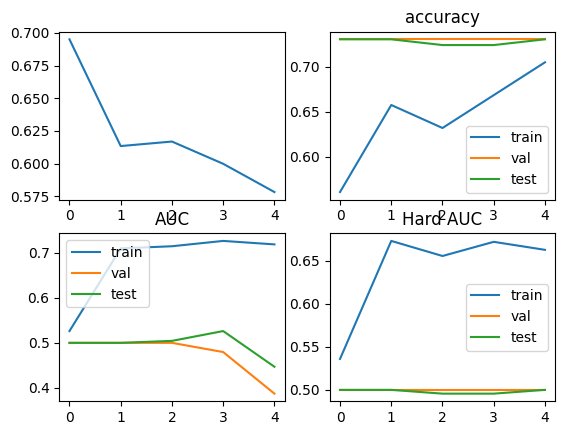

best auc, hard auc, accuracy
0.5 0.5 0.7307692307692307
final auc, hard auc, accuracy
0.44684628237259816 0.5 0.7307692307692307


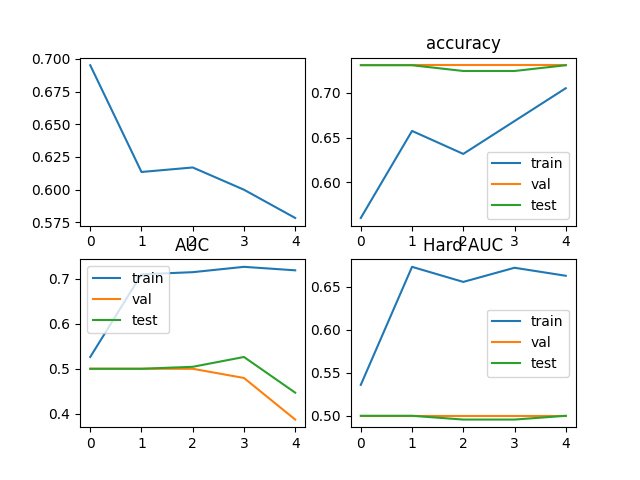

In [ ]:
# 18 layers was used in the medmnist
# with 126 it does best, but its a bit more parameters than the resnet below
# I could try 123, this is a tiny bit more but pretty close
# I will do 120
reload(models)
net = models.RotNet18(n0=120,n1=n_labels)
# 126 gives 11 million parameters, the resnet below is only 10 million, so we could do a bit less
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 120
out['n_parameters'] = models.count_parameters(net)

out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet18_n0120_out = out


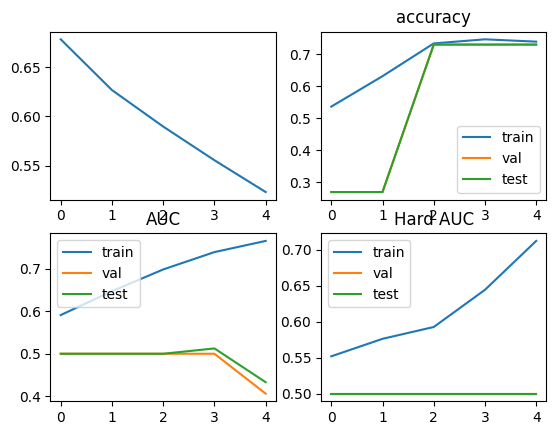

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.4329573934837092 0.5 0.7307692307692307


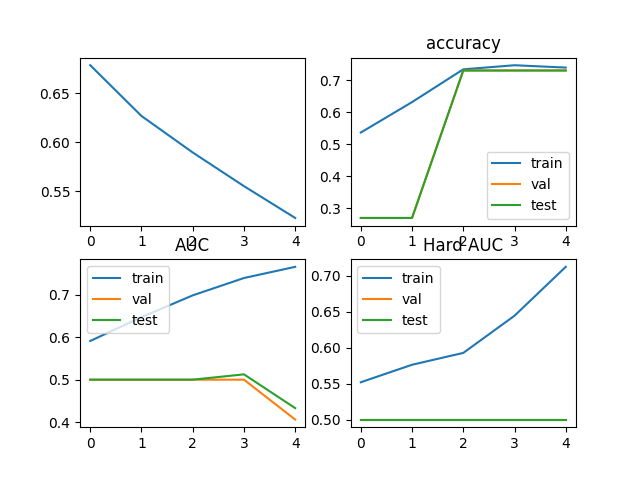

In [ ]:
# 18 layers was used in the medmnist
# for refnet I can use 159 parameters
reload(models)
net = models.RotNet18(n0=159,n1=n_labels,reflection=True)
# 126 gives 11 million parameters, the resnet below is only 10 million, so we could do a bit less
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 159
out['n_parameters'] = models.count_parameters(net)

out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
refnet18_n0159_out = out

# Now the 20 layer ones from cifar

## First the resnet

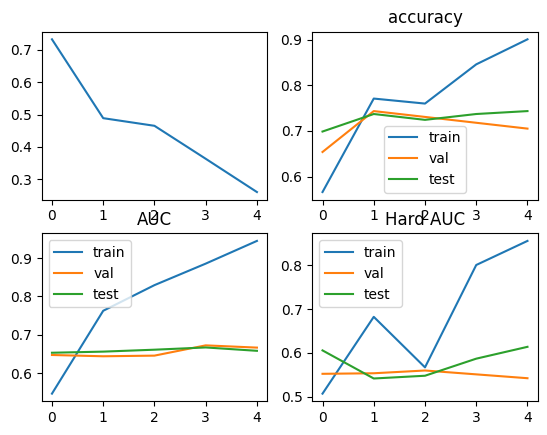

best auc, hard auc, accuracy
0.6670843776106934 0.5870927318295739 0.7371794871794872
final auc, hard auc, accuracy
0.658312447786132 0.6140350877192982 0.7435897435897436


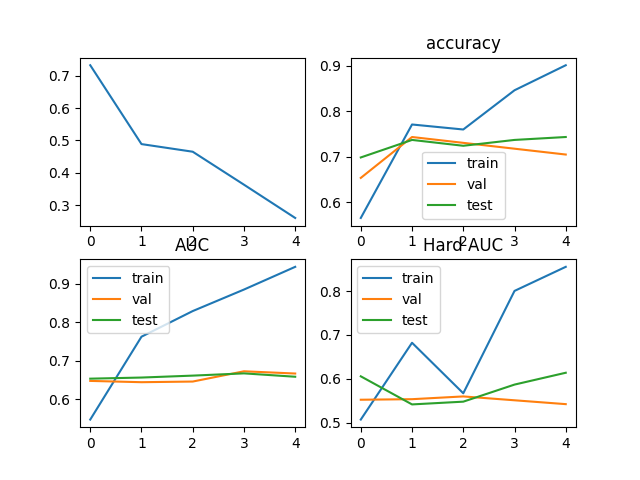

In [ ]:
# this is the resnet from the resnet paper for cifar10
# it has 16 channels at its input layer, and about 267K parameters
net = models.ResNet20(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 16
out['n_parameters'] = models.count_parameters(net)

out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
resnet20_out = out

## Now the same number of feature maps

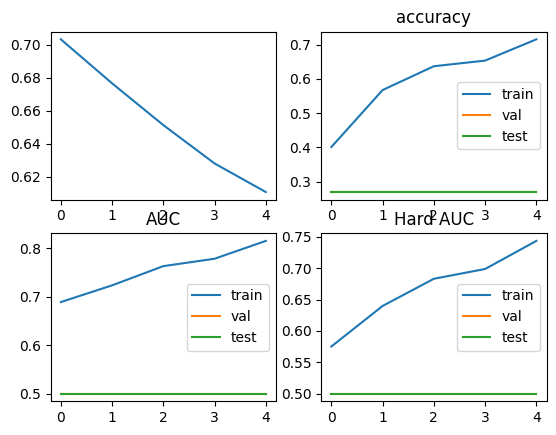

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.5 0.5 0.2692307692307692


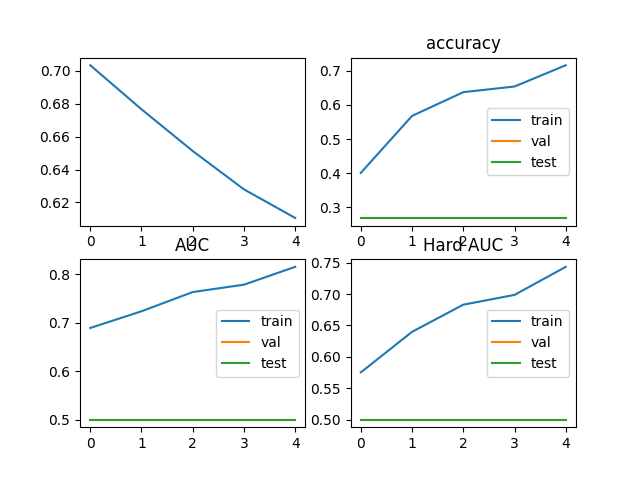

In [ ]:
# 20 layers is from cifar
# default is 15 parameters, note this tends to be too little to do a good job
reload(models)
net = models.RotNet20(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 15
out['n_parameters'] = models.count_parameters(net)
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_out = out

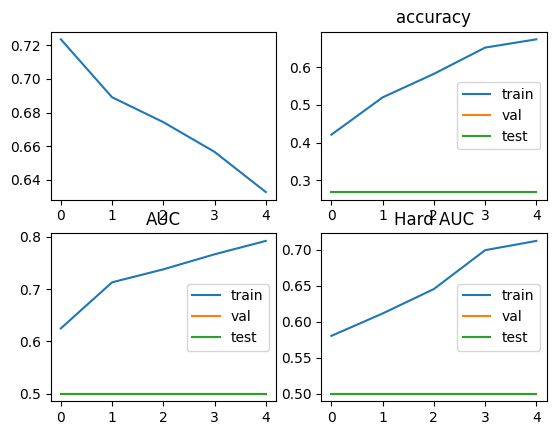

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.5 0.5 0.2692307692307692


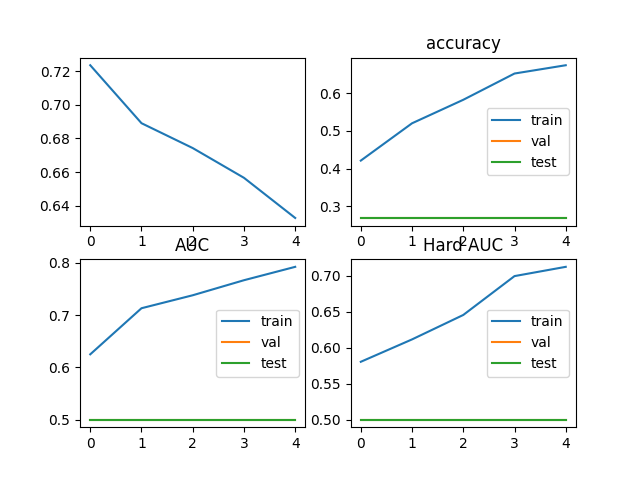

In [ ]:
# 20 layers is from cifar
# default is 15 parameters, note this tends to be too little to do a good job
# try with reflection equivariance too, it's way fewer parameters
reload(models)
net = models.RotNet20(n1=n_labels,reflection=True)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 15
out['n_parameters'] = models.count_parameters(net)
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
refnet20_out = out

## Now the same number of independent feature maps

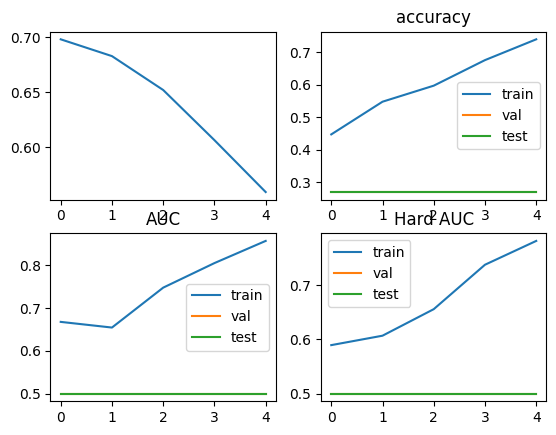

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.5 0.5 0.2692307692307692


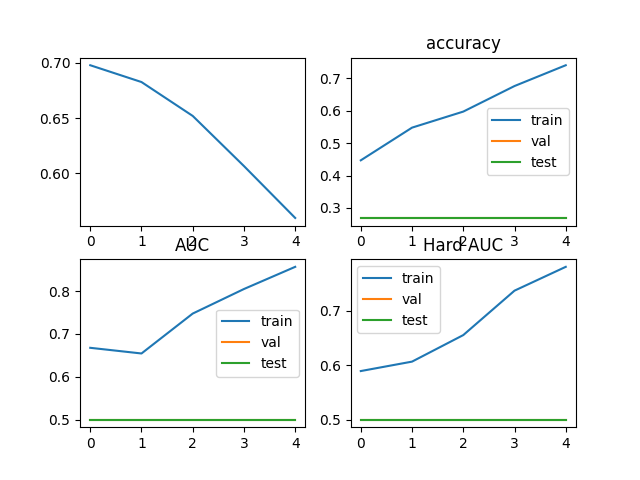

In [ ]:
# 20 layers is from cifar
# instead of matching parameters, match the number of scalar + vector components
# the resnet20 uses 16 channels, so I'll do 8 scalar and 8 vector for 24 channels
net = models.RotNet20(n0=24,n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 24
out['n_parameters'] = models.count_parameters(net)
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_n024_out = out

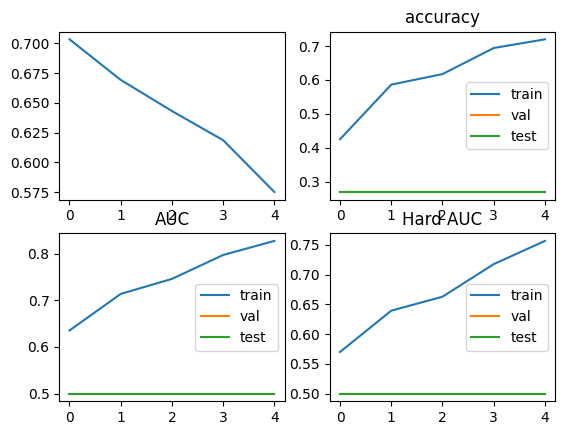

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.5 0.5 0.2692307692307692


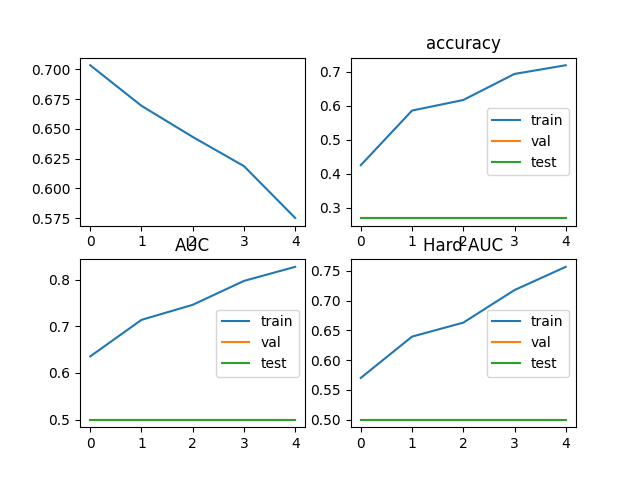

In [ ]:
# 20 layers is from cifar
# instead of matching parameters, match the number of scalar + vector components
# the resnet20 uses 16 channels, so I'll do 8 scalar and 8 vector for 24 channels
net = models.RotNet20(n0=24,n1=n_labels,reflection=True)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 24
out['n_parameters'] = models.count_parameters(net)
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
refnet20_n024_out = out

## Now the same number of parameters

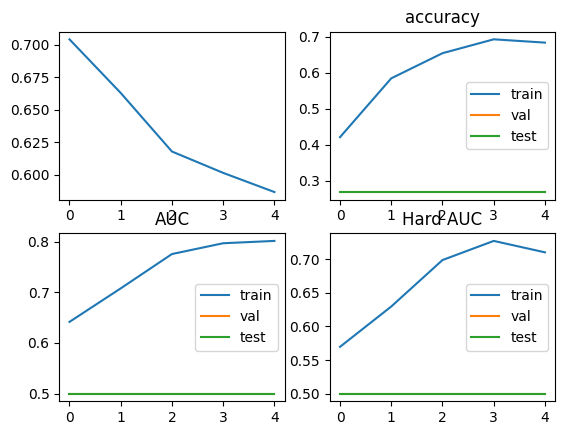

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.5 0.5 0.2692307692307692


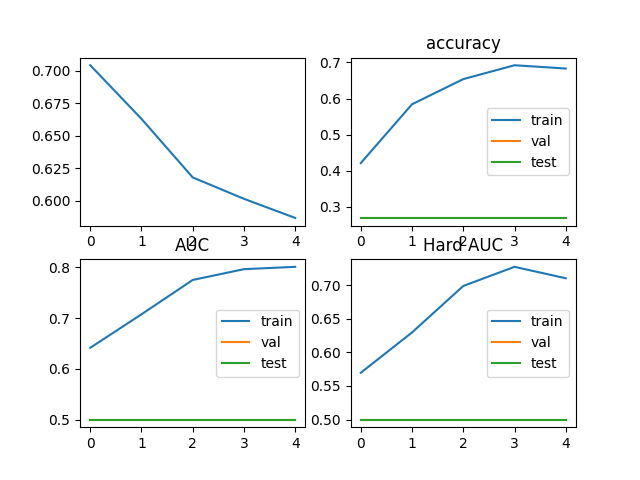

In [ ]:
# 20 layers is from cifar
# extra channels so it matches parameters
# below is about we want less than 260K
net = models.RotNet20(n0=30,n1=n_labels)
print(models.count_parameters(models.ResNet20()))
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 30
out['n_parameters'] = models.count_parameters(net)
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_n030_out = out

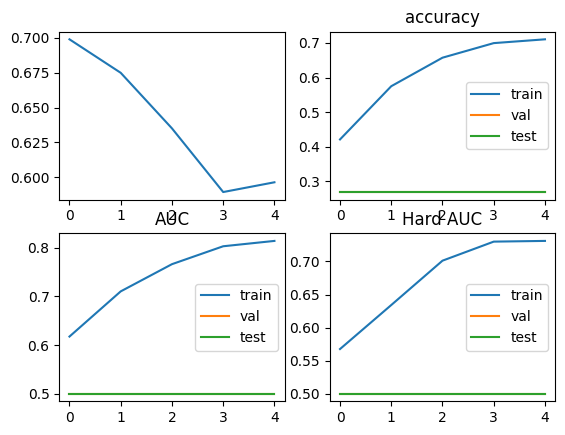

best auc, hard auc, accuracy
0.5 0.5 0.2692307692307692
final auc, hard auc, accuracy
0.5 0.5 0.2692307692307692


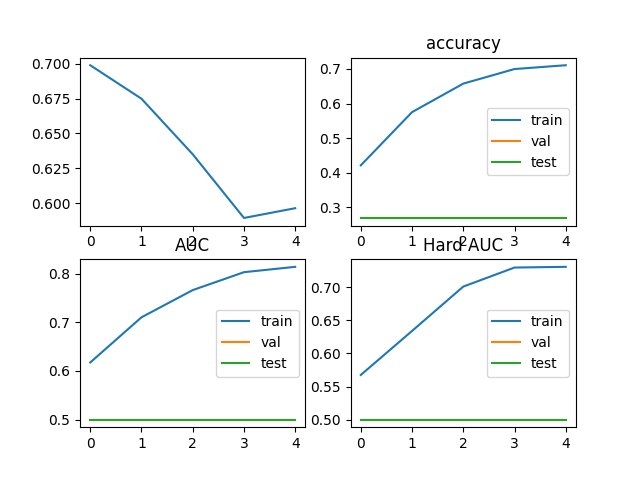

In [ ]:
# 20 layers is from cifar
# extra channels so it matches parameters
# below is about we want less than 260K
net = models.RotNet20(n0=39,n1=n_labels,reflection=True)
print(models.count_parameters(models.ResNet20()))
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 30
out['n_parameters'] = models.count_parameters(net)
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
refnet20_n039_out = out

# plot the data here

In [ ]:
[k for k in out]

['fig',
 'net',
 'accuracy_test',
 'accuracy_val',
 'accuracy_train',
 'auc_test',
 'auc_val',
 'auc_train',
 'hard_auc_test',
 'hard_auc_val',
 'hard_auc_train',
 'n0',
 'n_parameters']

In [ ]:
keys = ['accuracy_train', 'accuracy_val','accuracy_test', 
        'auc_train', 'auc_val', 'auc_test',
        'hard_auc_train', 'hard_auc_val', 'hard_auc_test']

# rotnet18 defaults to 63 channels, so doing 66 is not very differet
# rotnet20 had 15 channels efault
outputs = [resnet18_out,rotnet18_out,rotnet18_n096_out,rotnet18_n0120_out,refnet18_out,refnet18_n096_out, refnet18_n0159_out, resnet20_out, rotnet20_out,rotnet20_n024_out,rotnet20_n030_out,refnet20_out,refnet20_n024_out,refnet20_n039_out]
names = ['resnet18_64', 'rotnet18_63', 'rotnet18_96','rotnet18_120',      'refnet18_63','refnet18_96','refnet18_159',         'resnet20_16','rotnet20_15','rotnet20_24','rotnet20_30',       'refnet20_15','refnet20_24','refnet20_39']



In [ ]:


def plot_evaluation(names,outputs,measure):

    fig,ax = plt.subplots(1,2,sharey=True,sharex=True)

    k = '_'.join([measure,'test'])

    colors = ['r' if 'rot' in n else ('m' if 'ref' in n else 'b') for n in names]

    # this is the best
    data = []
    for out in outputs:
        ind = np.argmax(out[k.replace('test','val')])
        data.append(out[k][ind])
    
    ax[0].bar(names, data, color=colors)
    ax[0].set_ylim(np.min(data)-0.01,np.max(data)+0.01)
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(30)
        tick.set_horizontalalignment('right')
    ax[0].set_title(f'{measure.upper()}, best on validation')

    # this is the last
    data1 = [out[k][-1] for out in outputs]
    ax[1].bar(names, data1, color=colors)
    #ax[1].set_ylim(np.min(data1)-0.01,np.max(data1)+0.01)
    ax[0].set_ylim(np.min(data+data1)-0.01,np.max(data+data1)+0.01)
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(30)
        tick.set_horizontalalignment('right')
    ax[1].set_title(f'{measure.upper()}, last iteration')


    fig.subplots_adjust(bottom=0.15)
    return fig,ax

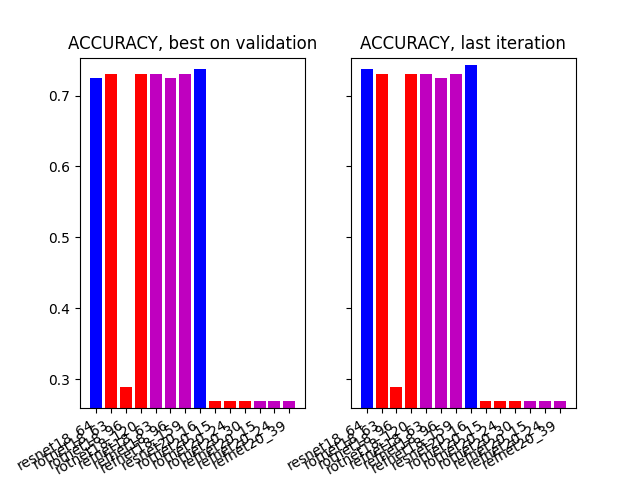

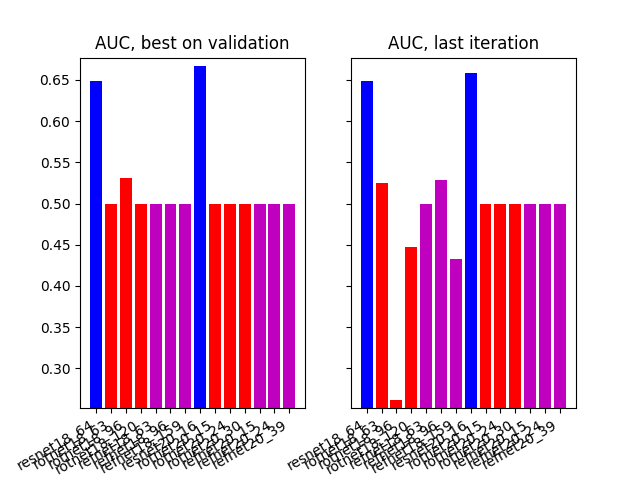

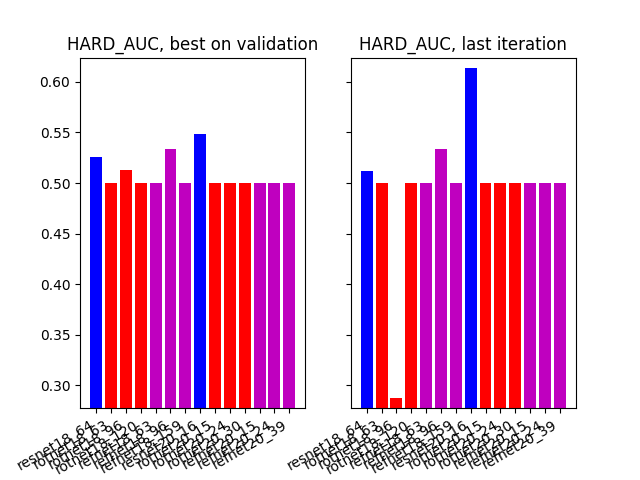

In [ ]:
measures = ['accuracy','auc','hard_auc']
for measure in measures:
    fig,ax = plot_evaluation(names,outputs,measure)

# comparing
There are are a few ways we could compare models on "equal footing"

1. We could use the same number of feature maps.
1. We could use the same number of parameters
1. We could count vector components as one feature and then use the same number of feature maps.

# TODO
make sure outputs are saved.  They should be named according to their architecture.  The dataset they are trained on.  And which repeat they are.